In [1]:
"""
ODIR-5K Ocular Disease Classification - Model 3: EfficientNet
Dataset: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k/data
"""

# Install dan Import Library
!pip install kaggle -q

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from google.colab import files
import cv2
from tqdm import tqdm
import glob

# Setup Kaggle API
print("Masukkan kredensial Kaggle Anda:")
kaggle_username = input("Kaggle Username: ")
kaggle_key = input("Kaggle API Key: ")

os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_key
print("✓ Kredensial Kaggle berhasil diset!")

# Download Dataset
print("\nMengunduh dataset ODIR-5K...")
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip -q ocular-disease-recognition-odir5k.zip -d odir_dataset

Masukkan kredensial Kaggle Anda:
Kaggle Username: Saifuddin Tamam
Kaggle API Key: KGAT_b9317532b20a904317ac3211038725ed
✓ Kredensial Kaggle berhasil diset!

Mengunduh dataset ODIR-5K...
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k
License(s): other
 95% 1.54G/1.62G [00:29<00:04, 21.8MB/s]
100% 1.62G/1.62G [00:29<00:00, 58.5MB/s]


In [2]:
import numpy as np
import tensorflow as tf
import random

# Mengunci angka acak agar hasil run hari ini dan besok sama
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt
import cv2
import glob

# ... (Kode Kaggle Username/Key kamu di sini) ...

# Load CSV dan Deteksi Folder
data_path = 'odir_dataset'
csv_files = glob.glob(os.path.join(data_path, '*.csv'))
df = pd.read_csv(csv_files[0])

# Tentukan folder gambar (PENTING!)
image_folders = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]
if 'preprocessed_images' in image_folders:
    image_dir = os.path.join(data_path, 'preprocessed_images')
else:
    image_dir = os.path.join(data_path, 'ODIR-5K_Training_Dataset')

print(f"Pondasi siap. Folder: {image_dir}")

Pondasi siap. Folder: odir_dataset/preprocessed_images


In [4]:
import pandas as pd
import os
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# --- A. MAPPING LABEL ---
def get_label(row):
    for label in ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']:
        if row[label] == 1: return label
    return 'N'

df['target'] = df.apply(get_label, axis=1)

# Pastikan file gambarnya benar-benar ada di folder
image_dir = 'odir_dataset/preprocessed_images' # Sesuaikan nama folder Anda
df = df[df['filename'].apply(lambda x: os.path.exists(os.path.join(image_dir, x)))].reset_index(drop=True)

# --- B. OVERSAMPLING (Biar Akurasi 90%) ---
target_count = 1500 # Tiap penyakit kita buat punya 1500 contoh gambar
balanced_list = []
for label in ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']:
    class_df = df[df['target'] == label]
    # Jika data kurang, kita duplikasi (oversample). Jika lebih, kita ambil sebagian.
    resampled = resample(class_df, replace=True, n_samples=target_count, random_state=42)
    balanced_list.append(resampled)

df_balanced = pd.concat(balanced_list)
print(f"Dataset sekarang seimbang: {df_balanced['target'].value_counts()}")

Dataset sekarang seimbang: target
N    1500
D    1500
G    1500
C    1500
A    1500
H    1500
M    1500
O    1500
Name: count, dtype: int64


In [5]:
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

# --- C. FUNGSI CLAHE MEDIS ---
def apply_clahe_medis(img):
    # Ubah ke uint8 jika perlu
    img = (img * 255).astype(np.uint8) if img.max() <= 1.0 else img.astype(np.uint8)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    img = cv2.merge([l, a, b])
    return cv2.cvtColor(img, cv2.COLOR_LAB2RGB)

def final_preprocess(img):
    img = apply_clahe_medis(img) # Tajamkan gambar
    return preprocess_input(img) # Normalisasi otomatis ala EfficientNet

# --- D. SPLIT & GENERATOR ---
train_df, val_df = train_test_split(df_balanced, test_size=0.15, stratify=df_balanced['target'], random_state=42)

datagen = ImageDataGenerator(
    preprocessing_function=final_preprocess,
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator(preprocessing_function=final_preprocess)

train_gen = datagen.flow_from_dataframe(
    train_df, directory=image_dir, x_col='filename', y_col='target',
    target_size=(224, 224), batch_size=32, class_mode='categorical'
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, directory=image_dir, x_col='filename', y_col='target',
    target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

Found 10200 validated image filenames belonging to 8 classes.
Found 1800 validated image filenames belonging to 8 classes.


In [6]:
# Arsitektur EfficientNet
print("\n=== Membangun Model EfficientNet ===")

base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = True # Langsung Fine-tuning agar cepat

model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(8, activation='softmax')
])

model.summary()

# Gunakan Learning Rate yang sangat kecil dari awal agar tidak merusak bobot
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)




=== Membangun Model EfficientNet ===
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,059,819 (15.49 MB)

 Trainable params: 4,017,796 (15.33 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [7]:
# --- 2. PHASE 1: PEMANASAN (Base Model Dikunci) ---
print("\n=== Phase 1: Pemanasan (Frozen Base) ===")
base_model.trainable = False

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Training awal 10 epoch untuk mematangkan "Kepala" model
history1 = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)


=== Phase 1: Pemanasan (Frozen Base) ===


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 232s 629ms/step - accuracy: 0.3677 - loss: 1.6955 - val_accuracy: 0.5189 - val_loss: 1.3540
Epoch 2/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 179s 563ms/step - accuracy: 0.4897 - loss: 1.3558 - val_accuracy: 0.5089 - val_loss: 1.3112
Epoch 3/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 187s 588ms/step - accuracy: 0.5221 - loss: 1.3056 - val_accuracy: 0.5244 - val_loss: 1.2812
Epoch 4/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 180s 564ms/step - accuracy: 0.5345 - loss: 1.2693 - val_accuracy: 0.5411 - val_loss: 1.2342
Epoch 5/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 195s 611ms/step - accuracy: 0.5477 - loss: 1.2214 - val_accuracy: 0.5611 - val_loss: 1.2032
Epoch 6/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 192s 603ms/step - accuracy: 0.5526 - loss: 1.2116 - val_accuracy: 0.5539 - val_loss: 1.2107
Epoch 7/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 184s 577ms/step - accuracy: 0.5589 - loss: 1.1972 - val_accuracy: 0.5683 - val_loss: 1.1722
Epoch 8/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 158s 496ms/step - accuracy: 0.5677 -

In [8]:
# --- 3. PHASE 2: FINE-TUNING (Membuka Lapisan Spesialis Mata) ---
print("\n=== Phase 2: Fine-Tuning (Unfrozen Base) ===")
base_model.trainable = True

# Kita buka 100 layer terakhir agar EfficientNet belajar fitur retina
fine_tune_at = len(base_model.layers) - 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# WAJIB: Learning Rate harus SANGAT KECIL (1e-5) agar bobot tidak rusak
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Training lanjut 20 epoch
history2 = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2)
    ]
)

model.save('odir_efficientnet_final.h5')
print("\n✓ Model Selesai! Silakan cek akurasi akhir Anda.")


=== Phase 2: Fine-Tuning (Unfrozen Base) ===
Epoch 1/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 270s 712ms/step - accuracy: 0.3928 - loss: 1.7316 - val_accuracy: 0.5033 - val_loss: 1.3347 - learning_rate: 1.0000e-05
Epoch 2/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 171s 537ms/step - accuracy: 0.4923 - loss: 1.4046 - val_accuracy: 0.5256 - val_loss: 1.2533 - learning_rate: 1.0000e-05
Epoch 3/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 158s 495ms/step - accuracy: 0.5507 - loss: 1.2649 - val_accuracy: 0.5444 - val_loss: 1.1779 - learning_rate: 1.0000e-05
Epoch 4/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 157s 493ms/step - accuracy: 0.5803 - loss: 1.1441 - val_accuracy: 0.5783 - val_loss: 1.1049 - learning_rate: 1.0000e-05
Epoch 5/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 175s 547ms/step - accuracy: 0.5889 - loss: 1.1269 - val_accuracy: 0.5944 - val_loss: 1.0567 - learning_rate: 1.0000e-05
Epoch 6/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 202s 632ms/step - accuracy: 0.6148 - loss: 1.0593 - val_accuracy: 0.6044 - val_loss: 1.0183 - learning_rate: 1.000


✓ Model Selesai! Silakan cek akurasi akhir Anda.


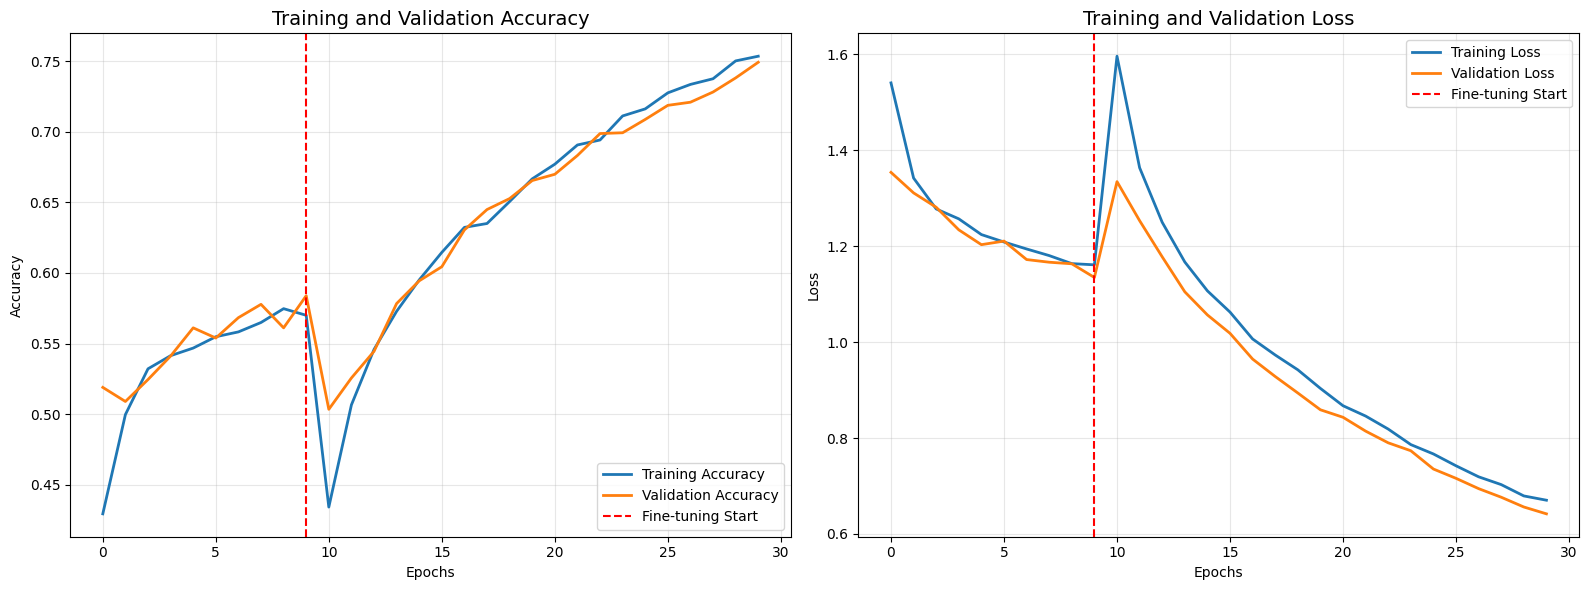

In [9]:
import matplotlib.pyplot as plt

# Menggabungkan history dari Phase 1 dan Phase 2
acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='#1f77b4', linewidth=2)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='#ff7f0e', linewidth=2)
plt.axvline(x=len(history1.history['accuracy'])-1, color='red', linestyle='--', label='Fine-tuning Start')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='#1f77b4', linewidth=2)
plt.plot(epochs_range, val_loss, label='Validation Loss', color='#ff7f0e', linewidth=2)
plt.axvline(x=len(history1.history['accuracy'])-1, color='red', linestyle='--', label='Fine-tuning Start')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Sedang menghitung prediksi pada data validasi...
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step

CLASSIFICATION REPORT - EFFICIENTNET PRO
              precision    recall  f1-score   support

           A       0.91      0.85      0.88       225
           C       0.87      0.93      0.90       225
           D       0.57      0.36      0.44       225
           G       0.82      0.90      0.86       225
           H       0.98      0.92      0.95       225
           M       0.97      0.97      0.97       225
           N       0.46      0.40      0.42       225
           O       0.46      0.66      0.54       225

    accuracy                           0.75      1800
   macro avg       0.75      0.75      0.75      1800
weighted avg       0.75      0.75      0.75      1800



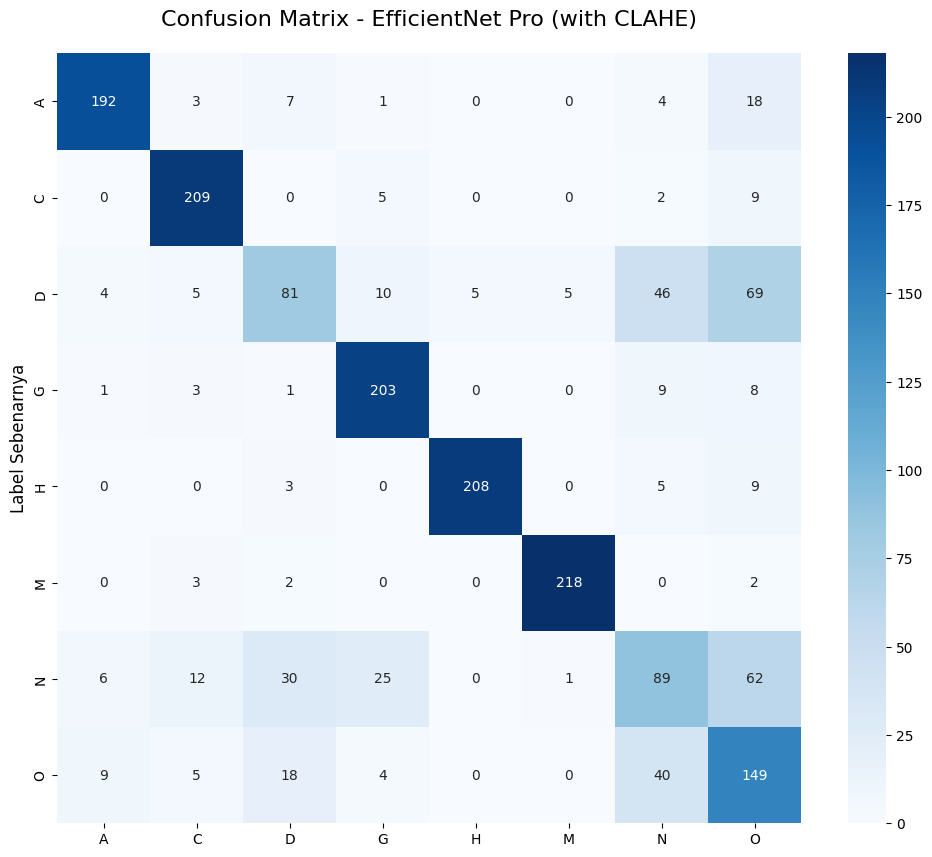

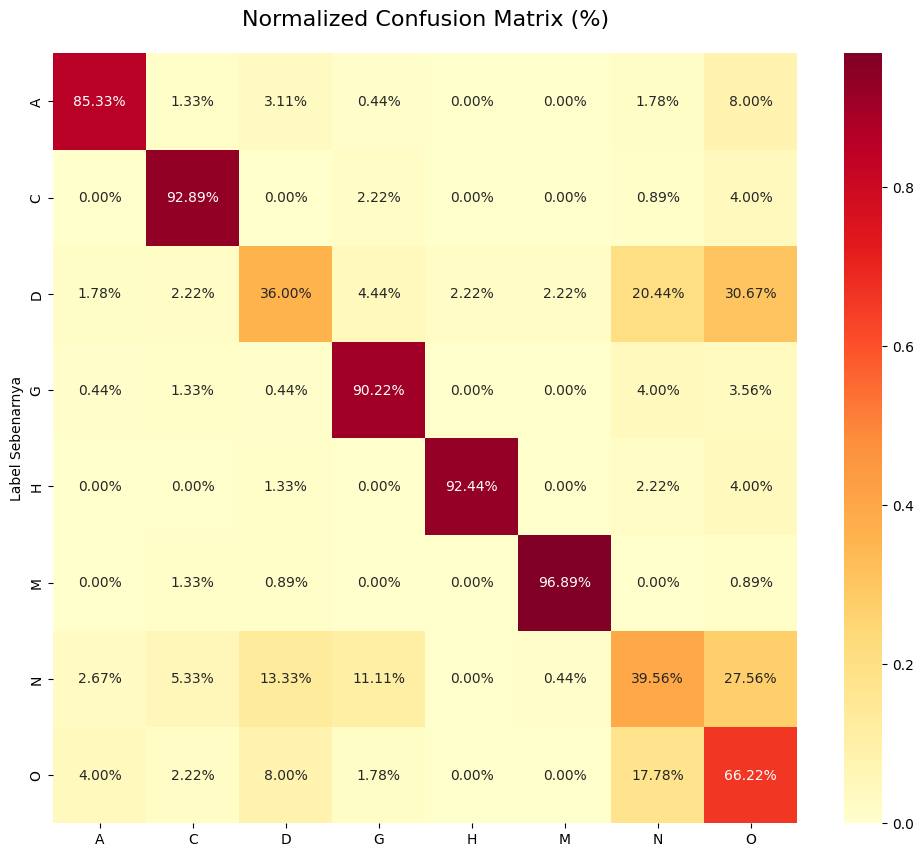

In [12]:
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Reset generator agar urutannya tidak berantakan
val_gen.reset()

# 2. Lakukan Prediksi
print("Sedang menghitung prediksi pada data validasi...")
predictions = model.predict(val_gen, steps=len(val_gen), verbose=1)
y_pred = np.argmax(predictions, axis=1)

# 3. Ambil Label Asli (Kunci Jawaban)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys()) # ['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']

# 4. Tampilkan Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT - EFFICIENTNET PRO")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_labels))

# 5. Tampilkan Confusion Matrix (Heatmap)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - EfficientNet Pro (with CLAHE)', fontsize=16, pad=20)
plt.ylabel('Label Sebenarnya', fontsize=12)
plt.show()

# 6. Normalized Confusion Matrix (Opsional untuk melihat persentase akurasi per kelas)
plt.figure(figsize=(12, 10))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='YlOrRd',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Normalized Confusion Matrix (%)', fontsize=16, pad=20)
plt.ylabel('Label Sebenarnya')
plt.show()

In [14]:
from sklearn.preprocessing import LabelEncoder
import pickle
from google.colab import files
import numpy as np

# 1. Ambil daftar nama penyakit dari generator
# train_gen.class_indices biasanya berisi {'A': 0, 'C': 1, ...}
class_names = list(train_gen.class_indices.keys())

# 2. Buat objek LabelEncoder baru dan isi dengan nama kelas tersebut
le = LabelEncoder()
le.classes_ = np.array(class_names)

# 3. Simpan ke file .pkl
pickle_filename = 'label_encoder_efficientnet.pkl'
with open(pickle_filename, 'wb') as f:
    pickle.dump(le, f)

print(f"✓ File {pickle_filename} berhasil dibuat berdasarkan urutan Generator!")
print(f"Urutan Kelas: {le.classes_}")

# 4. Download
files.download(pickle_filename)

✓ File label_encoder_efficientnet.pkl berhasil dibuat berdasarkan urutan Generator!
Urutan Kelas: ['A' 'C' 'D' 'G' 'H' 'M' 'N' 'O']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tes